In [2]:
import os
import random
from matplotlib import pyplot as plt
import cv2

import numpy as np
import pandas as pd

from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from keras.metrics import Precision, Recall

import keras_tuner as kt
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [3]:
top_dir = 'C:/Users/coco/Untitled Folder'
train_dir = top_dir + '/train'
test_dir = top_dir + '/test'

train_real = os.listdir(train_dir + '/REAL')
train_fake = os.listdir(train_dir + '/FAKE')

In [4]:
# Plot k-number of images from the dataset

def plot_im(directory, k):

    files = os.listdir(directory)
    im = random.choices(files, k = k)

    fig = plt.figure()

    for i in range(k):
        im_i = cv2.imread(directory + im[i])
        fig.add_subplot(int(np.sqrt(k)), int(np.sqrt(k)), i + 1)
        plt.imshow(im_i)
        plt.axis('off')
    
    return plt

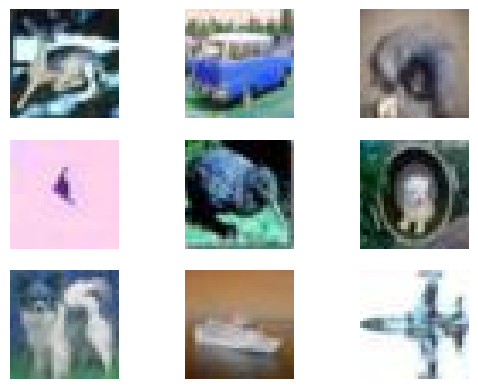

In [5]:
real_im = plot_im(directory = train_dir + '/REAL/', k = 9)

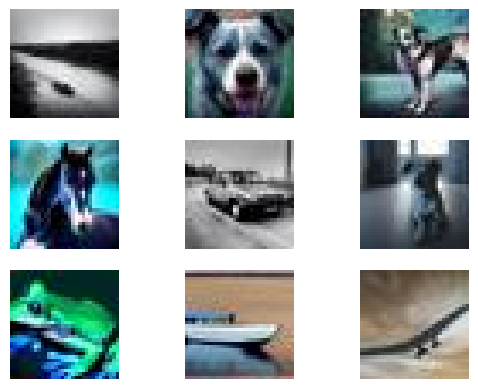

In [6]:
fake_im = plot_im(directory = train_dir + '/FAKE/', k = 9)

In [7]:
# Generate tf datasets

train = image_dataset_from_directory(
    train_dir,
    label_mode = 'binary',
    image_size = (32, 32)
)

test = image_dataset_from_directory(
    test_dir,
    label_mode = 'binary',
    image_size = (32, 32)
)

Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [ ]:
simple_model = Sequential([
    Rescaling(scale = 1./255),
    Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
    MaxPooling2D(),
    Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units = 64),
    BatchNormalization(),
    Activation('relu'),
    Dense(units = 1, activation = 'sigmoid')
])

simple_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', Precision(), Recall()]
)

simple_model.fit(train, validation_data = test, epochs = 5)

Epoch 1/5
2104/3125 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.8430 - loss: 0.3550 - precision: 0.8404 - recall: 0.8445

In [ ]:
# Hyperparameter tuning with keras_tuner

def model_builder(hp):
    
    # Hyperparameters
    dense_units = hp.Int('dense_units', min_value = 16, max_value = 128, step = 16)
    conv2d_filters_0 = hp.Int('conv_filters_0', min_value = 16, max_value = 128, step = 16)
    conv2d_filters_1 = hp.Int('conv_filters_1', min_value = 16, max_value = 128, step = 16)
    dropout_rate = hp.Int('dropout_rate', min_value = 0, max_value = 5, step = 1)
    learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    
    model = Sequential([
        Rescaling(scale = 1./255),
        Conv2D(filters = conv2d_filters_0, kernel_size = 3, activation = 'relu'),
        MaxPooling2D(),
        Conv2D(filters = conv2d_filters_1, kernel_size = 3, activation = 'relu'),
        MaxPooling2D(),
        Dropout(rate = dropout_rate/10),
        Flatten(),
        Dense(units = dense_units),
        BatchNormalization(),
        Activation('relu'),
        Dense(units = 1, activation = 'sigmoid')
    ])
    
    model.compile(
        optimizer = Adam(learning_rate = learning_rate),
        loss = 'binary_crossentropy',
        metrics = ['accuracy', Precision(), Recall()]
    )
    
    return model

In [ ]:
# Optimize model for validation accuracy

stop_early = EarlyStopping(monitor = 'val_accuracy', patience = 3)

tuner = kt.Hyperband(
    hypermodel = model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'tuning',
    overwrite = True
)

tuner.search(
    train,
    validation_data = test,
    callbacks = [stop_early]
)

In [ ]:
optimal_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(optimal_hps)

history = model.fit(
    train,
    validation_data = test,
    epochs = 20,
    callbacks = [stop_early]
)

In [ ]:
model.summary()
model.save('AIdetect.h5')
model.save('my_model.keras')